# Preprocessor
   1. Convert TIFF video to individual TIFF images
        > Clearing the folder and index+1 to have the range 1-300 added
   2. Cellular Segmentation
        > Done by utilizing the CellPose library
   3. Identify the Largest circle detected
        > Output: radius and centroid 
   4. Establish a bounding rectangular area around the circle
        > OpenCV cv2.boundingRect( ) used
   5. Perform cropping based on the bounding rectangular
   6. Save processed data

#### 1. Converting TIFF

In [10]:
import os
import numpy as np
import tifffile
from PIL import Image

# Read the image
imageAll = tifffile.imread('CaSki17.tif')
lengthOfStack = imageAll.shape[0]  # Get the length of the stack
dirToStore = "C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/"

# Check if the directory exists, if not, create it
if not os.path.exists(dirToStore):
    os.makedirs(dirToStore)
else:
    # Clear the directory if it's not empty
    for file in os.listdir(dirToStore):
        os.remove(os.path.join(dirToStore, file))

for index in range(lengthOfStack):  # Loop through each frame
    image = np.array(imageAll[index, :, :], dtype=np.uint16)
    image = Image.fromarray(image) # Convert to PIL Image
    image.save(f"{dirToStore}{index+1}.tif")


<tifffile.TiffTag 5033 @530880> coercing invalid ASCII to bytes


#### CellPose

Radius of the biggest detected membrane: 55.901798248291016


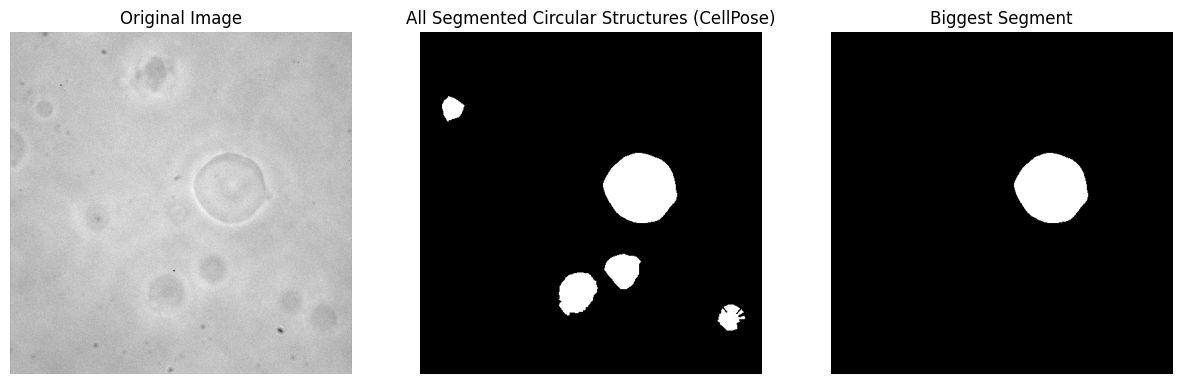

In [82]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Contrast stretching
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Segment membranes
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

max_radius = 0
max_contour = None

contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    if radius > max_radius:
        max_radius = radius
        max_contour = contour

print("Radius of the biggest detected membrane:", max_radius)

# Extract the segmented area of the biggest contour
biggest_segment_mask = np.zeros_like(image)
cv2.drawContours(biggest_segment_mask, [max_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

# Display the segmented membranes
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks_uint16, cmap='gray')
plt.title('All Segmented Circular Structures (CellPose)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(biggest_segment_mask, cmap='gray')
plt.title('Biggest Segment')
plt.axis('off')

plt.show()


#### Adding bounding rectangle

Radius of the biggest detected membrane: 55.901798248291016
Center coordinates of the biggest membrane: 330 233
Bounding rectangle coordinates (with 5 pixels added to each side): 269 176 390 291


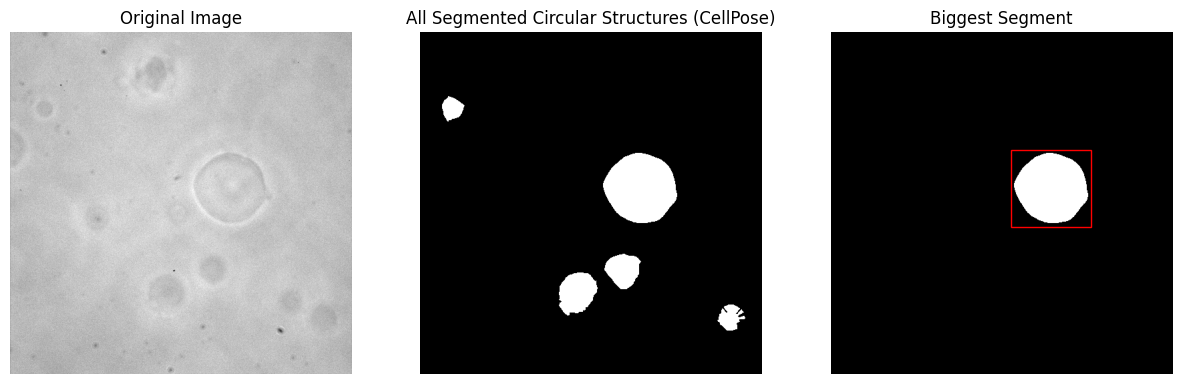

In [92]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt

image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Contrast stretching
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Segment membranes
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

max_radius = 0
max_contour = None

contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    if radius > max_radius:
        max_radius = radius
        max_contour = contour

print("Radius of the biggest detected membrane:", max_radius)

# Calculate the centroid of the biggest contour
M = cv2.moments(max_contour)
center_x = int(M["m10"] / M["m00"])
center_y = int(M["m01"] / M["m00"])

print("Center coordinates of the biggest membrane:", center_x, center_y)

# Extract the segmented area of the biggest contour
biggest_segment_mask = np.zeros_like(image)
cv2.drawContours(biggest_segment_mask, [max_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

# Find bounding rectangle around the biggest segment
x, y, w, h = cv2.boundingRect(max_contour)
# Add 10 pixels to each side of the bounding rectangle
x -= 5
y -= 5
w += 10
h += 10
print("Bounding rectangle coordinates (with 5 pixels added to each side):", x, y, x + w, y + h)

# Display the segmented membranes
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks_uint16, cmap='gray')
plt.title('All Segmented Circular Structures (CellPose)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(biggest_segment_mask, cmap='gray')
plt.title('Biggest Segment')
plt.axis('off')

# Draw bounding rectangle on the image with 10 pixels added to each side
plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

plt.show()


#### Cropping and Saving

Biggest radius: 55.901798248291016
Centroid coordinates: 330 233
Bounding rectangle coordinates (+ 5 pixels): 269 176 390 291


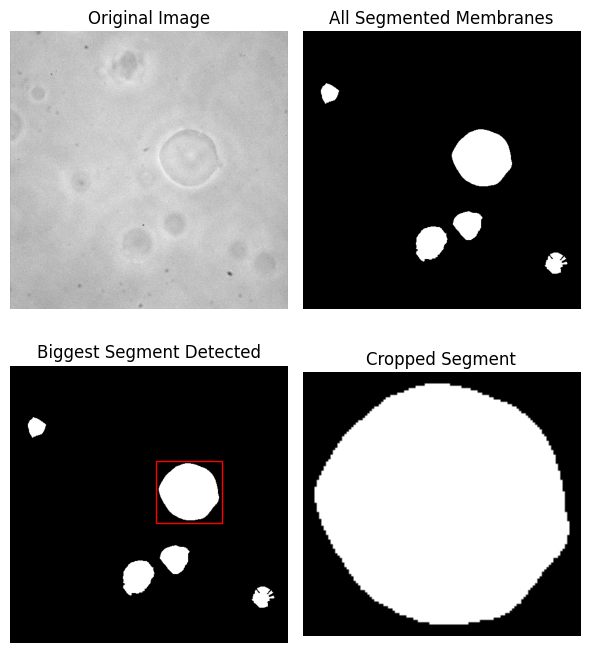

In [15]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to clear directory
def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

# Function to contrast stretch image
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# red the image
image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Segment membranes
masks, _, _, _ = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

# Find contours
contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with maximum area
max_contour = max(contours, key=cv2.contourArea)

# Calculate the biggest radius
(x_circle, y_circle), radius = cv2.minEnclosingCircle(max_contour)
print("Biggest radius:", radius)

# Centroid of the biggest contour
M = cv2.moments(max_contour)
center_x = int(M["m10"] / M["m00"])
center_y = int(M["m01"] / M["m00"])
print("Centroid coordinates:", center_x, center_y)

# Find bounding rectangle around the biggest segment
x, y, w, h = cv2.boundingRect(max_contour)
# Add 5 pixels to each side of the bounding rectangle
x -= 5
y -= 5
w += 10
h += 10
print("Bounding rectangle coordinates (+ 5 pixels):", x, y, x + w, y + h)

# Crop the segmented image using the bounding rectangle
cropped_segment = masks[y:y+h, x:x+w]

# Create a directory for segmented membranes
segmented_membranes_dir = os.path.join(os.getcwd(), "Segmented Membranes")
create_directory(segmented_membranes_dir)
clear_directory(segmented_membranes_dir)

# Save cropped segment
cv2.imwrite(os.path.join(segmented_membranes_dir, "cropped_segment.tif"), cropped_segment)

# Display images
plt.figure(figsize=(6, 7))

plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(masks_uint16, cmap='gray')
plt.title('All Segmented Membranes')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(masks_uint16, cmap='gray')
plt.title('Biggest Segment Detected')
plt.axis('off')
plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

plt.subplot(2, 2, 4)
plt.imshow(cropped_segment, cmap='gray')
plt.title('Cropped Segment')
plt.axis('off')

plt.tight_layout()
plt.show()


#### Experiment 1: Circumference

Biggest radius: 55.901798248291016
Centroid coordinates: 330 233


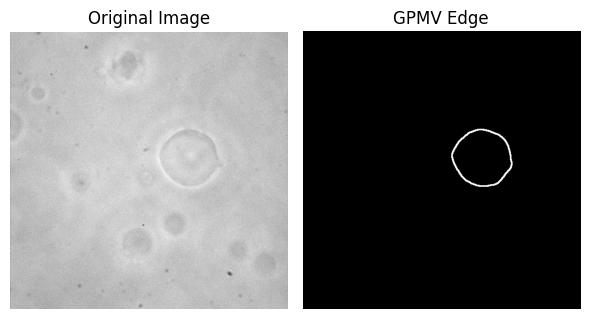

In [17]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to clear directory
def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

# Function to contrast stretch image
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Path to image
image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'

# Read image
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Segment membranes
masks, _, _, _ = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

# Find contours
contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with maximum area
max_contour = max(contours, key=cv2.contourArea)

# Calculate the biggest radius
(x_circle, y_circle), radius = cv2.minEnclosingCircle(max_contour)
print("Biggest radius:", radius)

# Calculate the centroid of the biggest contour
M = cv2.moments(max_contour)
center_x = int(M["m10"] / M["m00"])
center_y = int(M["m01"] / M["m00"])
print("Centroid coordinates:", center_x, center_y)

# Draw the contour of the biggest circle without filling it
circumference_image = np.zeros_like(image)
cv2.drawContours(circumference_image, [max_contour], -1, (255, 255, 255), thickness=2)

# Create a directory for segmented membranes
segmented_membranes_dir = os.path.join(os.getcwd(), "Segmented Membranes")
create_directory(segmented_membranes_dir)
# Clear the directory if it's not empty
clear_directory(segmented_membranes_dir)

# Save the circumference image
cv2.imwrite(os.path.join(segmented_membranes_dir, "circumference_image.tif"), circumference_image)

# Display images
plt.figure(figsize=(6, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(circumference_image, cmap='gray')
plt.title('GPMV Edge')
plt.axis('off')

plt.tight_layout()
plt.show()


#### Experiment 2: Bounding SQUARE and cropping

Biggest radius: 55.902 pixels
Diameter: 6.988 microns
Centroid coordinates: 330 233
Bounding rectangle coordinates: 269 173 390 294
Bounding rectangle area dimensions: 121 x 121


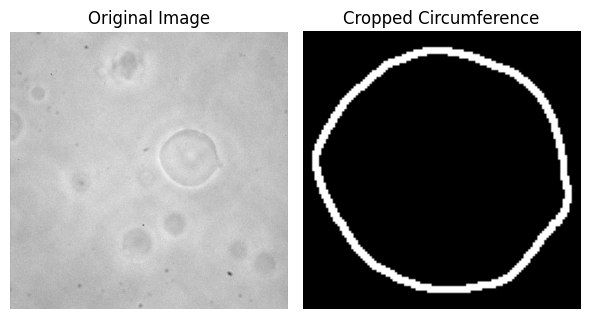

In [27]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to clear directory
def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

# Function to contrast stretch images
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Path to image
image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'

# Read image
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Segment membranes
masks, _, _, _ = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

# Find contours
contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with maximum area
max_contour = max(contours, key=cv2.contourArea)

# Calculate the biggest radius
(x_circle, y_circle), radius = cv2.minEnclosingCircle(max_contour)
print(f"Biggest radius: {radius:.3f} pixels")
diameter_microns = (radius*2)/16
print(f"Diameter: {diameter_microns:.3f} microns")

# Calculate the centroid of the biggest contour
M = cv2.moments(max_contour)
center_x = int(M["m10"] / M["m00"])
center_y = int(M["m01"] / M["m00"])
print("Centroid coordinates:", center_x, center_y)

# Calculate the bounding rectangle around the contour
x, y, w, h = cv2.boundingRect(max_contour)

# Determine the side length of the square
side_length = max(w, h)

# Create a square bounding box around the circumference
center_x = x + w // 2
center_y = y + h // 2
x_square = center_x - side_length // 2
y_square = center_y - side_length // 2

# Expand the square to ensure it covers the entire circumference
x_square -= 5
y_square -= 5
side_length += 10

print("Bounding rectangle coordinates:", x_square, y_square, x_square + side_length, y_square + side_length)
print("Bounding rectangle area dimensions:", side_length, "x", side_length)

# Crop the circumference image using the square bounding box
cropped_circumference = circumference_image[y_square:y_square+side_length, x_square:x_square+side_length]

# Create a directory for segmented membranes
segmented_membranes_dir = os.path.join(os.getcwd(), "Segmented Membranes")
create_directory(segmented_membranes_dir)
# Clear the directory if it's not empty
clear_directory(segmented_membranes_dir)

# Save cropped segmented circumference in tif format
cv2.imwrite(os.path.join(segmented_membranes_dir, "cropped_circumference.tif"), cropped_circumference)

# Display images
plt.figure(figsize=(6, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_circumference, cmap='gray')
plt.title('Cropped Circumference')
plt.axis('off')

plt.tight_layout()
plt.show()
